# Recursive Forecasting: skforecast Window-Features
Conda environment: `time-series`   
17 May 2024  

In [4]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom # You need this class for window-features instead of ForecasterAutoreg

In [3]:
# Configs

# Plot configs:
sns.set_context("paper", font_scale= 1.5)
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plotsize = (22, 5)
plt.rcParams['figure.figsize'] = plotsize

# Pandas config
pd.options.display.float_format = '{:,.4f}'.format
pd.options.display.max_columns = 200

## 1) Input data

In [5]:
# Electricity demand.
url = "https://raw.githubusercontent.com/tidyverts/tsibbledata/master/data-raw/vic_elec/VIC2015/demand.csv"
df = pd.read_csv(url)

df.drop(columns=["Industrial"], inplace=True)

# Convert the integer Date to an actual date with datetime type
df["date"] = df["Date"].apply(
    lambda x: pd.Timestamp("1899-12-30") + pd.Timedelta(x, unit="days")
)

# Create a timestamp from the integer Period representing 30 minute intervals
df["date_time"] = df["date"] + \
    pd.to_timedelta((df["Period"] - 1) * 30, unit="m")

df.dropna(inplace=True)

# Rename columns
df = df[["date_time", "OperationalLessIndustrial"]]

df.columns = ["date_time", "demand"]

# Resample to hourly
df = (
    df.set_index("date_time")
    .resample("H")
    .agg({"demand": "sum"})
)

df.head()

,demand
date_time,
2002-01-01 00:00:00,"6,919.3661"
2002-01-01 01:00:00,"7,165.9742"
2002-01-01 02:00:00,"6,406.5430"
2002-01-01 03:00:00,"5,815.5378"
2002-01-01 04:00:00,"5,497.7329"


In [17]:
# Split into train and test

# We leave the last February in the test set
end_train = '2014-12-31 23:59:59'
X_train = df.loc[:end_train]
X_test  = df.loc[end_train:]

print(X_train.shape)
X_train.tail()

(113952, 1)


,demand
date_time,
2014-12-31 19:00:00,"7,818.4614"
2014-12-31 20:00:00,"7,801.2018"
2014-12-31 21:00:00,"7,516.4730"
2014-12-31 22:00:00,"7,571.3014"
2014-12-31 23:00:00,"8,352.9921"


In [18]:
print(X_test.shape)
X_test.head()

(1416, 1)


,demand
date_time,
2015-01-01 00:00:00,"7,804.0862"
2015-01-01 01:00:00,"7,174.3400"
2015-01-01 02:00:00,"6,654.2834"
2015-01-01 03:00:00,"6,429.5980"
2015-01-01 04:00:00,"6,412.7853"


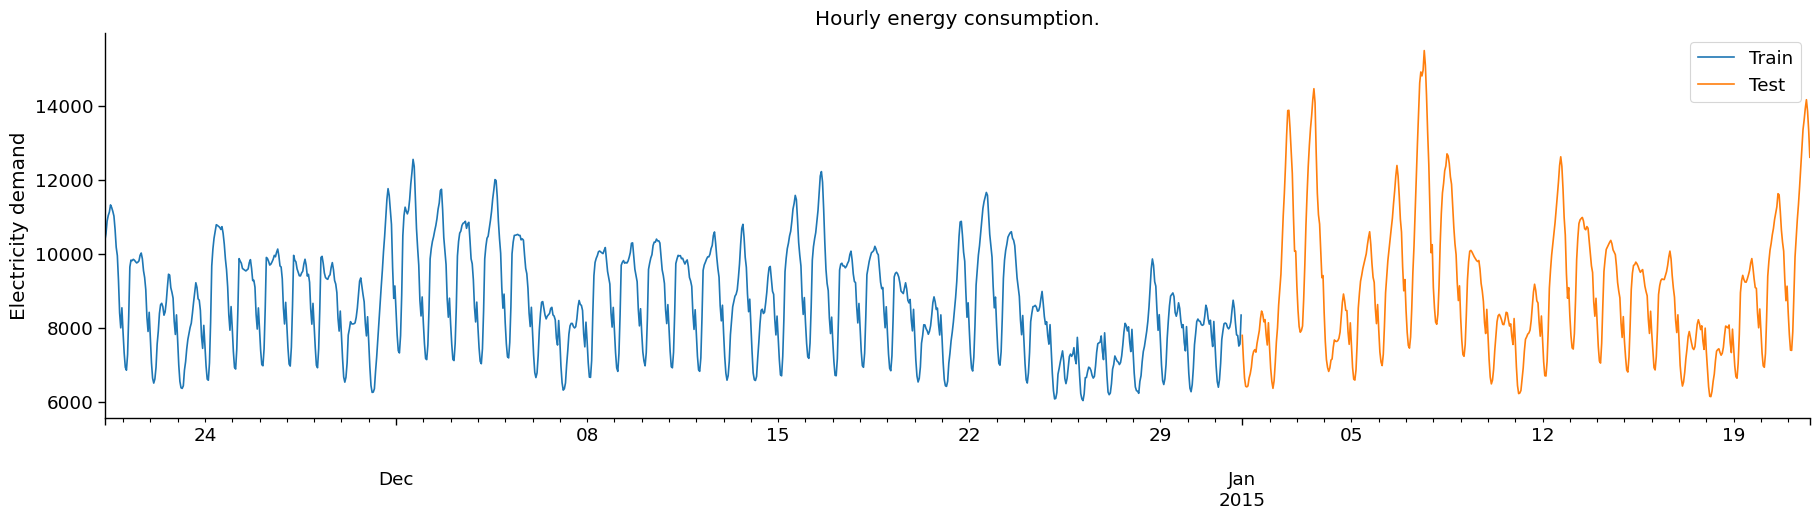

In [16]:
fig, ax = plt.subplots()

X_train.tail(1000).plot(ax=ax)
X_test.head(500).plot(ax=ax)

ax.set_title('Hourly energy consumption.')
ax.legend(["Train", "Test"])
ax.set_xlabel("")
ax.set_ylabel("Electricity demand")

plt.show()

## 2) Recursive Forecast

In [30]:
# To add window features, we need to create a function that creates those features
# For the moment, we cannot use: LagFeatures from Feature Engine. Because,
#   skforecast treats the time-series as a numpy vector instead of pandas (Feature engine)
def create_window_features(y: np.array) -> np.array:
    """In this function, we create:
        Lag: we create 10 lags, from lag1 to lag10
        Window features: mean with window size of 3 and 24
    Args:
        y (_type_): _description_
    Returns:
        _type_: _description_
    """
    # lag features 
    lags = y[-1:-11:-1] # Here, we create 10 lags, from lag1 to lag10
    # lag_5 = y[-5:-4] # Example of creating a specific lag
    
    # window features
    mean_3 = np.mean(y[-3:])   # window_size = 3
    mean_24 = np.mean(y[-24:]) # window_size = 24
    # put all together
    predictors = np.hstack([lags, mean_3, mean_24])
    return predictors

In [24]:
model = GradientBoostingRegressor(random_state=9, max_depth=3) 
model

GradientBoostingRegressor(random_state=9)

### 2.1) Train

In [31]:
# Feature names
feature_names = [f"lag_{i}" for i in range(1, 11)] + ["mean_3", "mean_24",]

forecaster = ForecasterAutoregCustom(
    regressor=model,
    fun_predictors=create_window_features,
    window_size=24,  # the size for the biggest window
    name_predictors=feature_names,
    forecaster_id="recursive"
)

# Train
forecaster.fit(
    y=X_train["demand"], # the series for the lags
)
forecaster

ForecasterAutoregCustom 
Regressor: GradientBoostingRegressor(random_state=9) 
Predictors created with function: create_window_features 
Transformer for y: None 
Transformer for exog: None 
Window size: 24 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2002-01-01 00:00:00'), Timestamp('2014-12-31 23:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: H 
Regressor parameters: {'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'random_state': 9, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False} 
fit_kw

In [32]:
# Let's explore the input
X_tmp, y_tmp = forecaster.create_train_X_y(
    y=X_train["demand"],
)

X_tmp.head()

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,mean_3,mean_24
date_time,,,,,,,,,,,,
2002-01-02 00:00:00,"6,863.8723","6,015.7502","6,255.7653","6,628.8395","6,509.9026","6,400.8444","6,527.0118","6,490.6698","6,221.4173","6,013.4966","6,378.4626","6,172.5641"
2002-01-02 01:00:00,"6,579.2199","6,863.8723","6,015.7502","6,255.7653","6,628.8395","6,509.9026","6,400.8444","6,527.0118","6,490.6698","6,221.4173","6,486.2808","6,158.3913"
2002-01-02 02:00:00,"6,990.8264","6,579.2199","6,863.8723","6,015.7502","6,255.7653","6,628.8395","6,509.9026","6,400.8444","6,527.0118","6,490.6698","6,811.3062","6,151.0935"
2002-01-02 03:00:00,"6,382.9150","6,990.8264","6,579.2199","6,863.8723","6,015.7502","6,255.7653","6,628.8395","6,509.9026","6,400.8444","6,527.0118","6,650.9871","6,150.1090"
2002-01-02 04:00:00,"5,896.9281","6,382.9150","6,990.8264","6,579.2199","6,863.8723","6,015.7502","6,255.7653","6,628.8395","6,509.9026","6,400.8444","6,423.5565","6,153.5002"


### 2.2) Predict

In [35]:
HORIZON = 24

predictions = forecaster.predict(
    steps=HORIZON,
)

pd.DataFrame(predictions).reset_index()

,index,pred
0,2015-01-01 00:00:00,"8,716.3105"
1,2015-01-01 01:00:00,"9,335.8490"
2,2015-01-01 02:00:00,"9,348.9574"
3,2015-01-01 03:00:00,"9,237.1507"
4,2015-01-01 04:00:00,"9,038.4903"
5,2015-01-01 05:00:00,"8,871.6502"
6,2015-01-01 06:00:00,"8,707.0997"
7,2015-01-01 07:00:00,"8,623.9825"
8,2015-01-01 08:00:00,"8,500.4842"
9,2015-01-01 09:00:00,"8,330.8083"


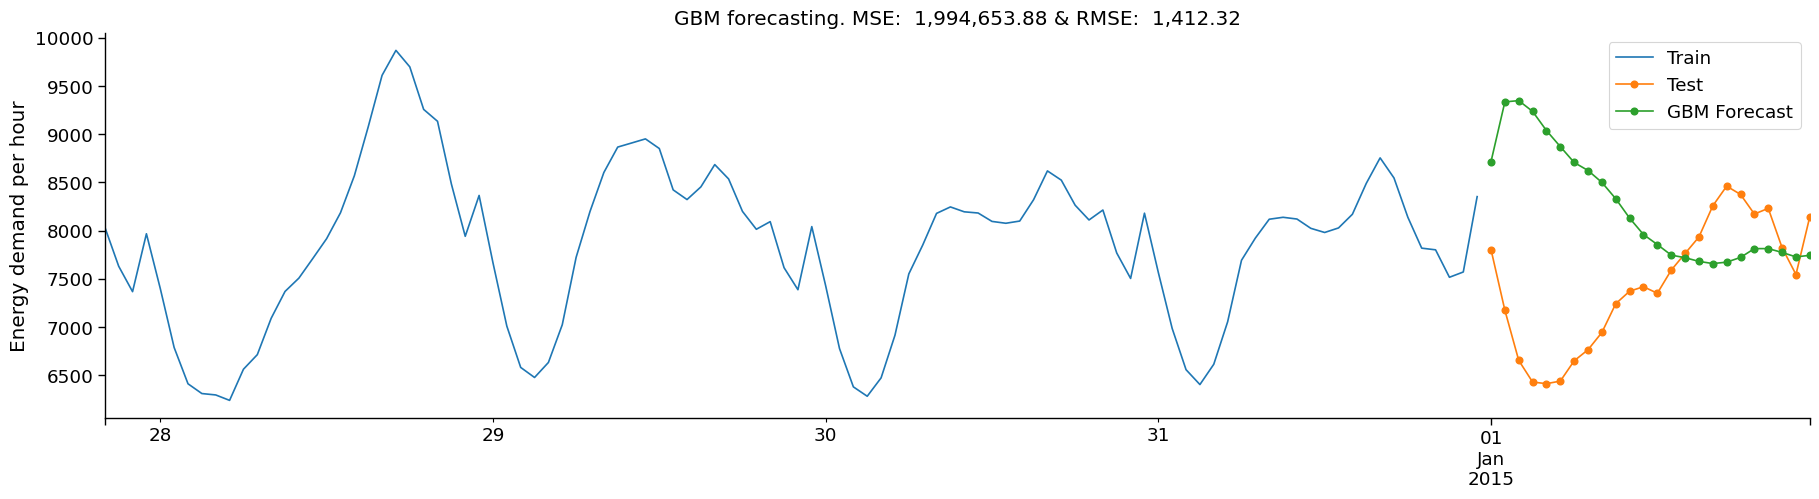

In [38]:
# MSE
error_mse = mean_squared_error(
                y_true = X_test["demand"].loc[predictions.index] , 
                y_pred = predictions,
                squared=True,
            )
# RMSE 
error_rmse = mean_squared_error(
                y_true = X_test["demand"].loc[predictions.index], 
                y_pred = predictions,
                squared=False,
            )

fig, ax = plt.subplots()

X_train.tail(100).plot(ax=ax)
X_test.head(24).plot(ax=ax, marker="o")
predictions.plot(ax=ax, marker="o")

ax.legend(["Train", "Test", "GBM Forecast"])
plt.title(f"GBM forecasting. MSE: {error_mse: ,.2f} & RMSE: {error_rmse: ,.2f}")
plt.ylabel("Energy demand per hour")
plt.xlabel("")

plt.show()

## 3) Feature importance

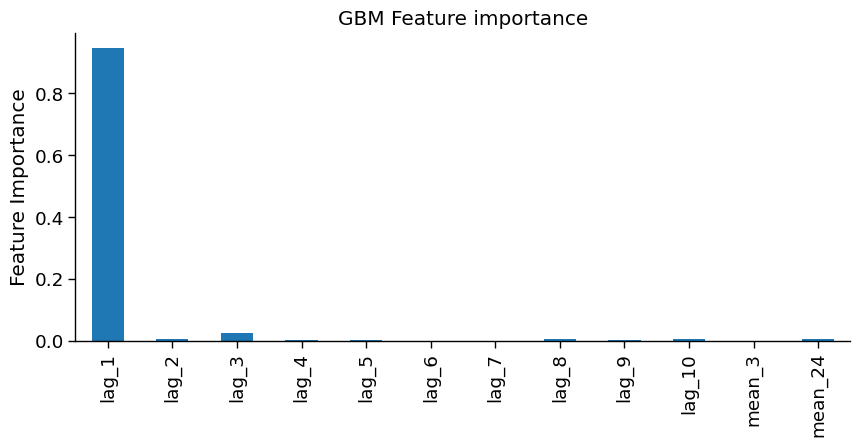

In [46]:
pd.Series(
    forecaster.regressor.feature_importances_,
    index=forecaster.regressor.feature_names_in_    
).plot(kind="bar", figsize=(10,4))

plt.title("GBM Feature importance")
plt.ylabel("Feature Importance")
plt.show()